# **CRISP-DM aplicado ao modelo House Prices**

## **1) Entendimento do Negócio**
**Objetivo:** prever "Price (in rupees)" a partir de características do imóvel para apoiar decisões de compra/venda e precificação.

In [26]:
# Imports
# ===============================================================
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap
import joblib

!pip install ydata-profiling
from ydata_profiling import ProfileReport

In [2]:
# Configs visuais
pd.set_option("display.max_columns", 200)
sns.set_theme(style="whitegrid")

## **2) Entendimento dos Dados**

In [4]:
df = pd.read_csv("house_prices.csv", quotechar='"', on_bad_lines="skip", low_memory=False)
print("✅ Base carregada:", df.shape)

✅ Base carregada: (187531, 21)


In [ ]:
df.head()

,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,Furnishing,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN
2,2,2 BHK Ready to Occupy Flat for sale in Sunrise...,Up for immediate sale is a 2 BHK apartment in ...,1.40 Cr,17500.0,thane,779 sqft,Ready to Move,10 out of 29,Resale,Unfurnished,East,Garden/Park,Sunrise by Kalpataru,2,NaN,1 Covered,Freehold,NaN,NaN,NaN
3,3,1 BHK Ready to Occupy Flat for sale Kasheli,This beautiful 1 BHK Flat is available for sal...,25 Lac,NaN,thane,530 sqft,Ready to Move,1 out of 3,Resale,Unfurnished,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
4,4,2 BHK Ready to Occupy Flat for sale in TenX Ha...,"This lovely 2 BHK Flat in Pokhran Road, Thane ...",1.60 Cr,18824.0,thane,635 sqft,Ready to Move,20 out of 42,Resale,Unfurnished,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,NaN,1 Covered,Co-operative Society,NaN,NaN,NaN


In [5]:
profile = ProfileReport(df, title="Relatório - House Prices", explorative=True)
profile.to_file("house_prices_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## **3) Preparação dos Dados**
- Drop de colunas 100% nulas/irrelevantes
- Parsing de colunas numéricas que vieram como texto
- Tratamento de nulos
- Codificação categórica (one-hot)
- Amostragem para controlar RAM

In [6]:
# 3.1 Remover colunas totalmente nulas ou pouco úteis para o baseline
cols_drop = ["Dimensions", "Plot Area", "Index", "Title", "Description"]
df = df.drop(columns=[c for c in cols_drop if c in df.columns], errors="ignore")

In [7]:
# 3.2 Função auxiliar para extrair números de strings (mantendo decimais)
def parse_number(s):
    if pd.isna(s):
        return np.nan
    # mantém dígitos, ponto e vírgula; remove o resto
    s = re.sub(r"[^0-9\.,]", "", str(s))
    # remove separadores de milhar (vírgula) e troca vírgula por ponto se necessário
    s = s.replace(",", "")
    try:
        return float(s) if s != "" else np.nan
    except:
        return np.nan

In [8]:
# 3.3 Converter para número colunas que costumam vir como texto
num_obj_cols = [
    "Amount(in rupees)", "Carpet Area", "Bathroom", "Balcony",
    "Car Parking", "Super Area", "Floor"
]
for col in num_obj_cols:
    if col in df.columns and df[col].dtype == "object":
        df[col] = df[col].apply(parse_number)

In [9]:
# 3.4 Definir target (y) e features (X)
target = "Price (in rupees)"
if target not in df.columns:
    raise ValueError(f"Coluna alvo '{target}' não encontrada no dataset.")

# Remover linhas sem preço (target nulo)
df = df[~df[target].isna()].copy()

In [10]:
# 3.5 Amostragem para reduzir RAM (ajuste se quiser usar toda a base)
N_SAMPLE = min(30000, len(df))  # até 30k linhas
df_sample = df.sample(N_SAMPLE, random_state=42).reset_index(drop=True)
print(f"🔎 Amostra usada no treino: {df_sample.shape}")

🔎 Amostra usada no treino: (30000, 16)


In [11]:
# 3.6 Separar X e y
y = df_sample[target].astype(float)
X = df_sample.drop(columns=[target])

In [12]:
# 3.7 One-hot encoding nas categóricas restantes
X = pd.get_dummies(X, drop_first=True)

In [36]:
# 3.8 Imputação simples (mediana) para faltantes numéricos
for col in X.columns:
    if X[col].isna().any():
        med = X[col].median()
        X[col] = X[col].fillna(med)

In [37]:
# Garantir que todas as variáveis categóricas sejam transformadas em numéricas
X = pd.get_dummies(X, drop_first=True)

In [38]:
# 3.9 Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("🔧 Formas finais:", "X_train:", X_train.shape, "| X_test:", X_test.shape)

🔧 Formas finais: X_train: (24000, 3469) | X_test: (6000, 3469)


## **4) Modelagem**
- Baseline: RandomForestRegressor (com limites p/ RAM)
- Modelo candidato: HistGradientBoostingRegressor (leve e eficiente)


In [15]:
# 4.1 Random Forest (baseline, mais interpretável via importâncias)
rf = RandomForestRegressor(
    n_estimators=120,
    max_depth=12,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [16]:
# 4.2 HistGradientBoosting (geralmente mais performático e eficiente)
hgb = HistGradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=None,
    max_iter=300,
    random_state=42
)
hgb.fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)

## **5) Avaliação**
- Métricas: MAE, RMSE, R²
- Correlação y_true vs y_pred
- Gráficos: dispersão, resíduos, histograma de resíduos


In [18]:
def avaliar(nome, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"\n📊 {nome}")
    print(f"MAE :  {mae:,.2f}")
    print(f"RMSE:  {rmse:,.2f}")
    print(f"R²  :  {r2:.4f}")
    return {"modelo": nome, "MAE": mae, "RMSE": rmse, "R2": r2}

res_rf  = avaliar("RandomForest", y_test, y_pred_rf)
res_hgb = avaliar("HistGradientBoosting", y_test, y_pred_hgb)


📊 RandomForest
MAE :  3,873.84
RMSE:  87,849.75
R²  :  0.0007

📊 HistGradientBoosting
MAE :  2,593.63
RMSE:  87,862.87
R²  :  0.0004


✅ SHAP para RandomForest gerado!


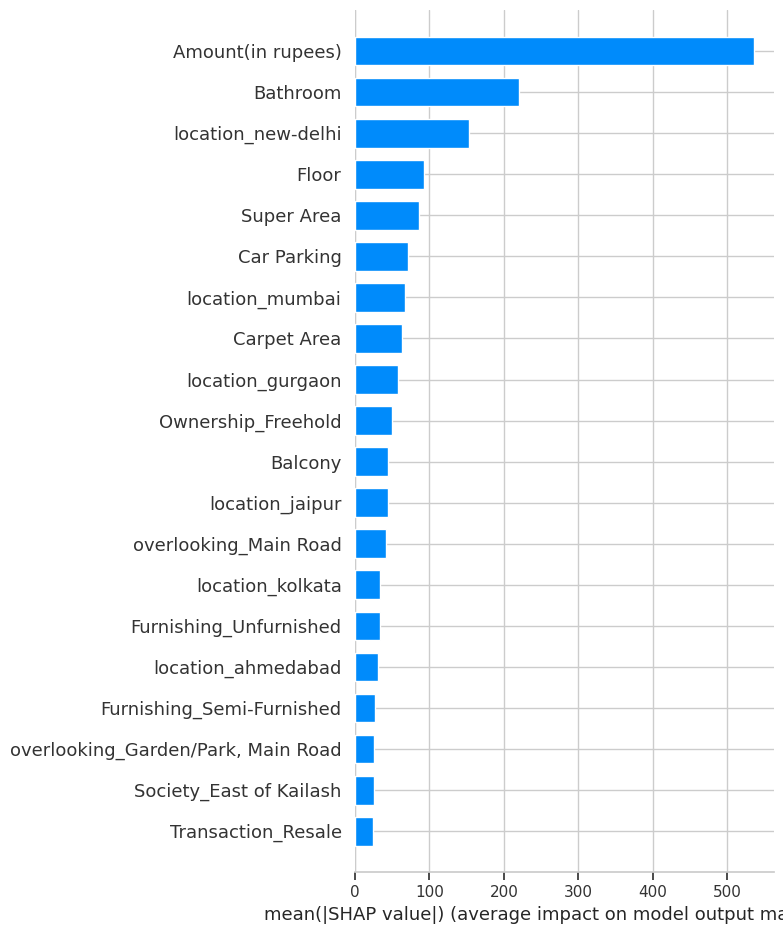

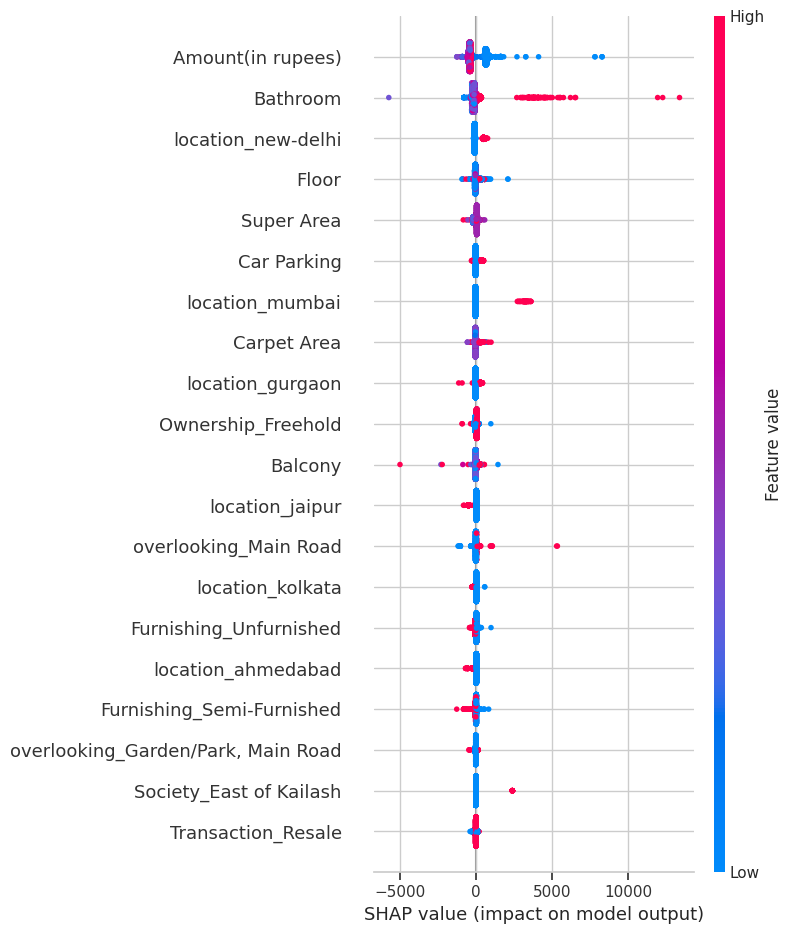

In [28]:
# Explicabilidade para RandomForest
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)

print("✅ SHAP para RandomForest gerado!")

# Importância global
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")

# Impacto individual nas features
shap.summary_plot(shap_values_rf, X_test)

In [39]:
print(X_test.dtypes.value_counts())
print(X_test.select_dtypes(include="object").head())

bool       3462
float64       7
Name: count, dtype: int64
Empty DataFrame
Columns: []
Index: [2308, 22404, 23397, 25058, 2664]


In [40]:
X_train = X_train.astype({col: "int" for col in X_train.select_dtypes("bool").columns})
X_test  = X_test.astype({col: "int" for col in X_test.select_dtypes("bool").columns})

In [43]:
# Explicabilidade para HistGradientBoosting
explainer_hgb = shap.Explainer(hgb, X_test)

# Desabilita o check de aditividade
shap_values_hgb = explainer_hgb(X_test, check_additivity=False)

print("✅ SHAP para HistGradientBoosting gerado sem erro!")

✅ SHAP para HistGradientBoosting gerado sem erro!


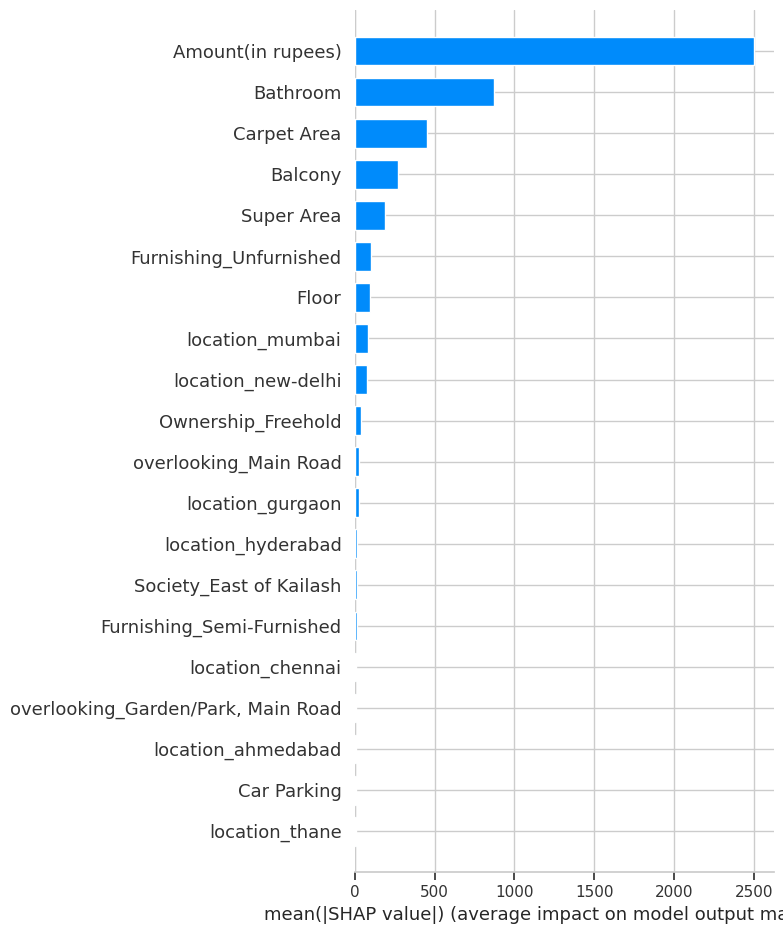

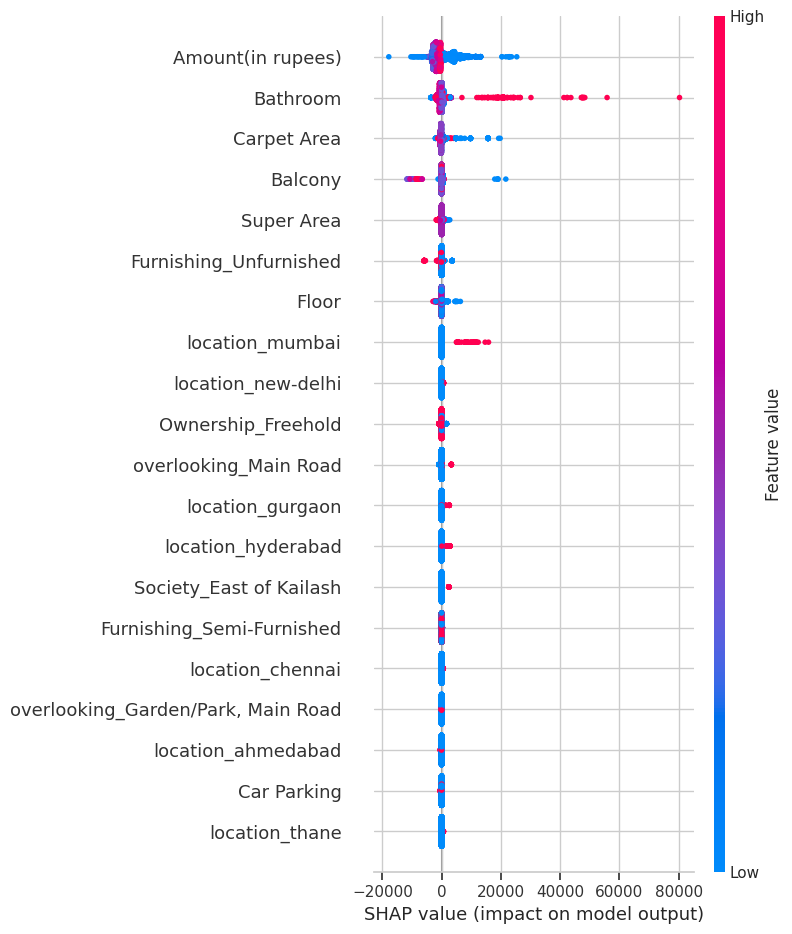

In [44]:
shap.summary_plot(shap_values_hgb, X_test, plot_type="bar")
shap.summary_plot(shap_values_hgb, X_test)

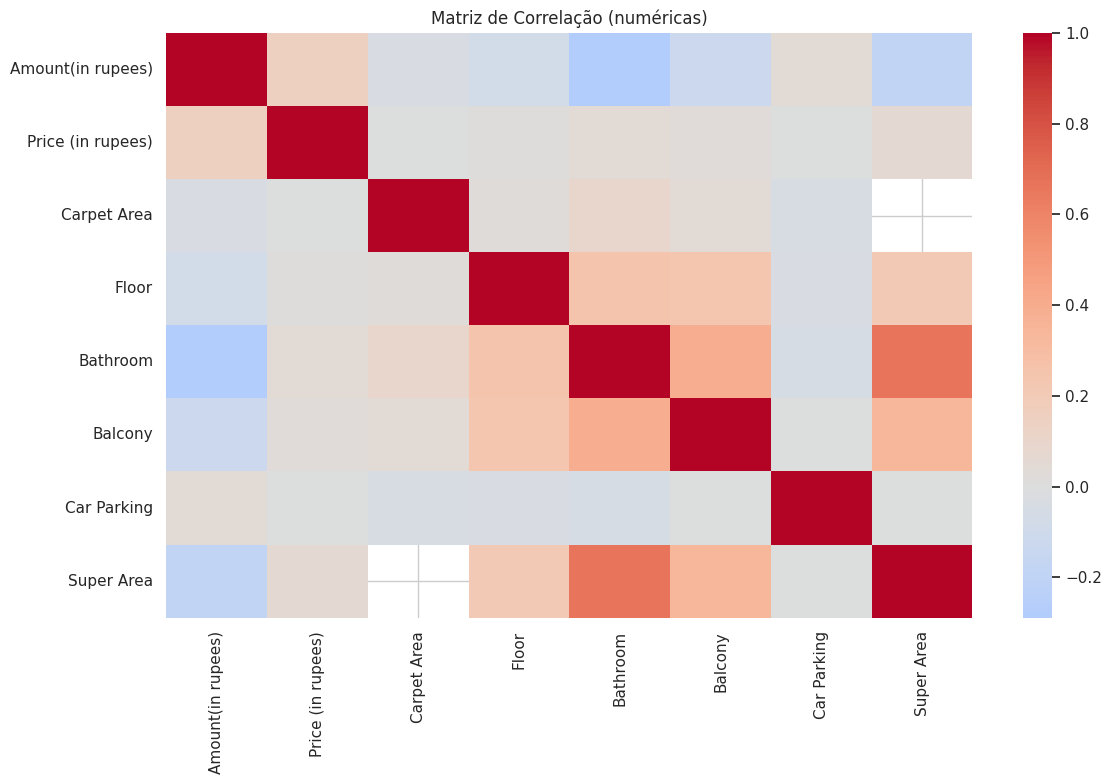

In [19]:
# 5.1 Matriz de correlação (features numéricas apenas)
plt.figure(figsize=(12,8))
sns.heatmap(df_sample.select_dtypes(include=np.number).corr(), cmap="coolwarm", center=0)
plt.title("Matriz de Correlação (numéricas)")
plt.tight_layout()
plt.show()

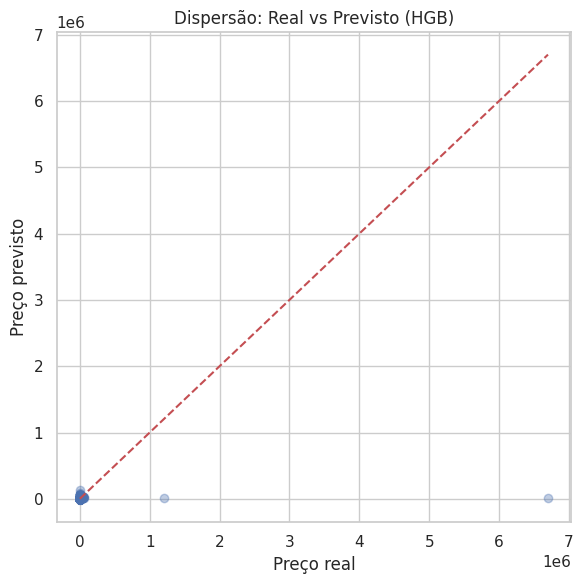

In [20]:
# 5.2 Dispersão y_true vs y_pred (modelo escolhido provisoriamente: HGB)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_hgb, alpha=0.35)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("Preço real")
plt.ylabel("Preço previsto")
plt.title("Dispersão: Real vs Previsto (HGB)")
plt.tight_layout()
plt.show()

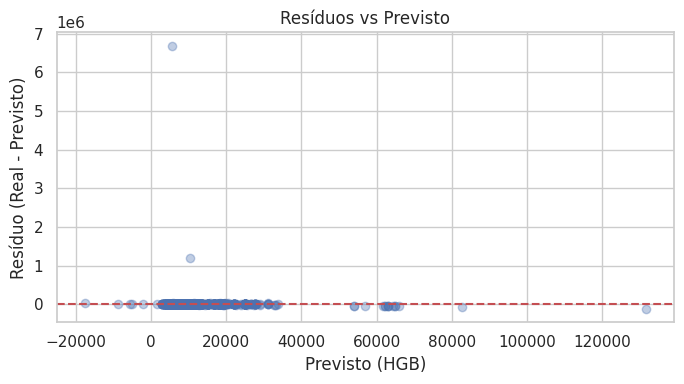

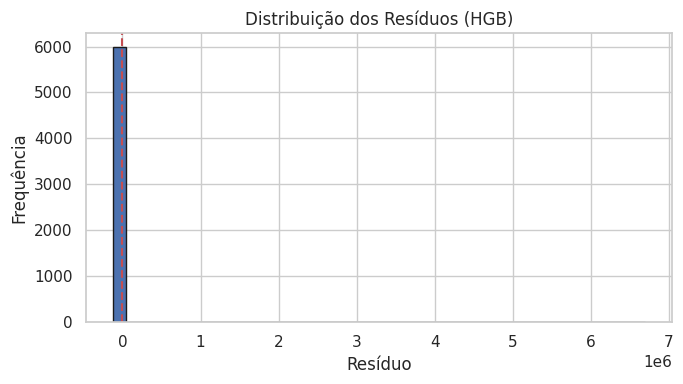

In [21]:
# 5.3 Resíduos (HGB)
residuos = y_test - y_pred_hgb

plt.figure(figsize=(7,4))
plt.scatter(y_pred_hgb, residuos, alpha=0.35)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Previsto (HGB)")
plt.ylabel("Resíduo (Real - Previsto)")
plt.title("Resíduos vs Previsto")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.hist(residuos, bins=40, edgecolor='k')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Resíduo")
plt.ylabel("Frequência")
plt.title("Distribuição dos Resíduos (HGB)")
plt.tight_layout()
plt.show()


🏆 Top 15 features (RF):
Amount(in rupees)            0.146026
Bathroom                     0.121369
location_mumbai              0.081219
Carpet Area                  0.071323
Floor                        0.045048
location_new-delhi           0.044748
Super Area                   0.039327
Society_East of Kailash      0.034227
Car Parking                  0.030104
Balcony                      0.025056
location_gurgaon             0.021824
Society_La Lagune Gurgaon    0.019419
overlooking_Main Road        0.014971
location_jaipur              0.014511
Furnishing_Unfurnished       0.013458
dtype: float64


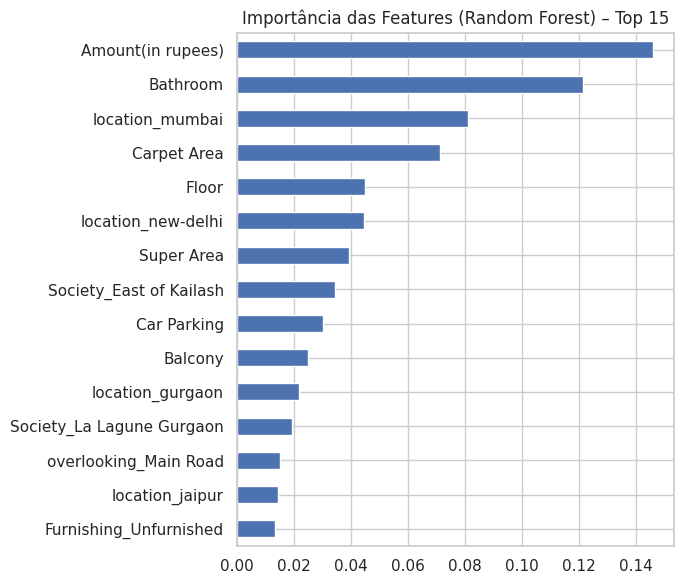

In [22]:
# 5.4 Importância de variáveis (RF) – útil para explicabilidade
rf_imp = pd.Series(rf.feature_importances_, index=X_train.columns)\
         .sort_values(ascending=False)
print("\n🏆 Top 15 features (RF):")
print(rf_imp.head(15))

plt.figure(figsize=(7,6))
rf_imp.head(15).sort_values().plot(kind="barh")
plt.title("Importância das Features (Random Forest) – Top 15")
plt.tight_layout()
plt.show()

In [23]:
# (Opcional) Importância por permutação no HGB – mais custosa, mas modelo-agnóstica
perm = permutation_importance(hgb, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
print("\n🔍 Top 15 features por permutação (HGB):")
print(perm_imp.head(15))


🔍 Top 15 features por permutação (HGB):
Bathroom                   0.004007
Amount(in rupees)          0.003527
Balcony                    0.001524
Furnishing_Unfurnished     0.000306
location_mumbai            0.000246
Carpet Area                0.000189
Super Area                 0.000154
Floor                      0.000059
location_gurgaon           0.000057
location_hyderabad         0.000036
Society_East of Kailash    0.000027
location_new-delhi         0.000014
Car Parking                0.000013
location_chennai           0.000007
location_ahmedabad         0.000004
dtype: float64


## **6) Implantação**
- Escolha do melhor modelo: menor MAE/RMSE e maior R².
- Salvar modelo final (aqui, escolhemos HGB se ele for melhor).

In [24]:
melhor = res_hgb if res_hgb["R2"] >= res_rf["R2"] else res_rf
melhor_nome = melhor["modelo"]
print(f"\n✅ Modelo escolhido para implantação: {melhor_nome}")

modelo_final = hgb if melhor_nome == "HistGradientBoosting" else rf
joblib.dump(modelo_final, f"modelo_house_prices_{melhor_nome}.pkl")
print(f"💾 Modelo salvo como: modelo_house_prices_{melhor_nome}.pkl")


✅ Modelo escolhido para implantação: RandomForest
💾 Modelo salvo como: modelo_house_prices_RandomForest.pkl


In [25]:
# (Opcional) Exemplo de predição com amostra
exemplo = X_test.iloc[:5].copy()
pred_exemplo = modelo_final.predict(exemplo)
print("\n🔮 Previsões de exemplo (5 linhas):")
print(pd.DataFrame({
    "y_real": y_test.iloc[:5].values,
    "y_prev": pred_exemplo
}))


🔮 Previsões de exemplo (5 linhas):
   y_real       y_prev
0  3846.0  6504.634448
1  5800.0  7765.352886
2  9960.0  7726.485575
3  5000.0  7458.424890
4  6384.0  8052.998368
